In [1]:
#Requires MCTS, POMDPs
#include(joinpath("MultiLanePOMDP","src","Multilane.jl"))
include(joinpath("..","src","Multilane.jl"))

function MCTS.generate(mdp::MLPOMDP,s::MLState,a::MLAction,rng::AbstractRNG)
  #println("hey")
  sp = next(rng,mdp,s,a)
  r = reward(mdp,s,a,sp)
  return (sp,r)
end


Use "Dict(a=>b, ...)" instead.

Use "Dict(a=>b, ...)" instead.


generate (generic function with 6 methods)

In [3]:
#Set up problem configuration
nb_lanes = 2
pp = PhysicalParam(nb_lanes,lane_length=200.) #2.=>col_length=8
r_crash = -1.
accel_cost = -1e-5
decel_cost = -5e-6
invalid_cost = -1e-5
lineride_cost = -1e-5
lanechange_cost = -2e-5
_discount = 1.
pomdp = MLPOMDP(nb_cars=3,nb_lanes=nb_lanes,phys_param=pp,p_fail_enter=-0.01,
            r_crash=r_crash,accel_cost=accel_cost,decel_cost=decel_cost,
invalid_cost=invalid_cost,lineride_cost=lineride_cost,lanechange_cost=lanechange_cost,discount=_discount)

MLPOMDP(3,800,3,#undef,-1.0,-1.0e-5,-5.0e-6,-1.0e-5,-1.0e-5,-2.0e-5,0.1,1.0,PhysicalParam(0.75,2.0,4.0,31.0,4.0,2.0,0.25,35.0,27.0,31.0,35.0,27.0,100,1,200.0,3,2400,[27.0,27.0808,27.1616,27.2424,27.3232,27.404,27.4848,27.5657,27.6465,27.7273  …  34.2727,34.3535,34.4343,34.5152,34.596,34.6768,34.7576,34.8384,34.9192,35.0],[0.0,0.250313,0.500626,0.750939,1.00125,1.25156,1.50188,1.75219,2.0025,2.25282  …  197.747,197.997,198.248,198.498,198.748,198.999,199.249,199.499,199.75,200.0]),[BehaviorModel(IDMParam(1.0,1.0,2.0,27.5,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1),BehaviorModel(IDMParam(1.5,1.5,1.4,27.5,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,2),BehaviorModel(IDMParam(2.0,2.0,0.8,27.5,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3),BehaviorModel(IDMParam(1.0,1.0,2.0,31.0,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,4),BehaviorModel(IDMParam(1.5,1.5,1.4,31.0,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5),BehaviorModel(IDMParam(2.0,2.0,0.8,31.0,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,6),BehaviorModel(IDMParam(1

In [4]:
# initialize the solver
# the hyper parameters in MCTS can be tricky to set properly
# n_iterations: the number of iterations that each search runs for
# depth: the depth of the tree (how far away from the current state the algorithm explores)
# exploration constant: this is how much weight to put into exploratory actions. 
# A good rule of thumb is to set the exploration constant to what you expect the upper bound on your average 
#  expected reward to be.

solver = MCTSSolver(n_iterations=100, depth=10, exploration_constant=1.0)

# initialize the policy by passing in your problem and the solver
policy = MCTSPolicy(solver, pomdp)

MCTS.MCTSPolicy(MCTS.MCTSSolver(100,10,1.0,MersenneTwister(Base.dSFMT.DSFMT_state(Int32[748398797,1073523691,-1738140313,1073664641,-1492392947,1073490074,-1625281839,1073254801,1875112882,1073717145  …  943540191,1073626624,1091647724,1073372234,-1273625233,-823628301,835224507,991807863,382,0]),[2.33132e-317,7.89483e-317,0.0,0.0,3.47447e-316,4.94066e-324,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,1.8231e-321,3.49152e-316,6.90166e-310,3.47729e-316,0.0],382,UInt32[0x00000000]),MCTS.RandomSolver(MersenneTwister(Base.dSFMT.DSFMT_state(Int32[748398797,1073523691,-1738140313,1073664641,-1492392947,1073490074,-1625281839,1073254801,1875112882,1073717145  …  943540191,1073626624,1091647724,1073372234,-1273625233,-823628301,835224507,991807863,382,0]),[2.33132e-317,7.89483e-317,0.0,0.0,3.47447e-316,4.94066e-324,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,1.8231e-321,3.49152e-316,6.90166e-310,3.47729e-316,0.0],382,UInt32[0x00000000])),false),MLPOMDP(3,800,3,#undef,-1.0,-1.0e-5,-5.0e-6,-1.0e-5,-1.0e-5

In [6]:
rng = MersenneTwister(9) # initialize a random number generator
n_ep = 1
Rs = [Float64[] for _=1:n_ep]#zeros(n_ep)
nb_early_term = 0
histS = Array{MLState,1}[]
histA = Array{MLAction,1}[]
for j = 1:n_ep
    push!(histS,MLState[])
    push!(histA,MLAction[])
    s = init(pomdp,rng)
    rtot = 0.0
    disc = 1.0
    for i = 1:100
        # get the action from our SARSOP policy
        a = action(policy, s) # the QMDP action function returns the POMDP action not its index like the SARSOP action function
        #if j == n_ep
            push!(histS[j],s)
            push!(histA[j],a)
        #end
        # compute the reward
        r = reward(pomdp, s, a)
        push!(Rs[j],r)
        rtot += disc*r
        if isterminal(pomdp,s,a)
            nb_early_term += 1
            break
        end
        disc *= discount(pomdp)
        print("\rEp:$j, t=$i")
        # transition the system state
        """
        trans_dist = transition(mdp, s, a)
        rand(rng, trans_dist, s)
        """
        s = next(rng,pomdp,s,a)
    end
    #Rs[j] = rtot
    print("\rTotal discounted reward: $rtot")
end

Total discounted reward: -0.0013850000000000008

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"i",50,1:100,true)

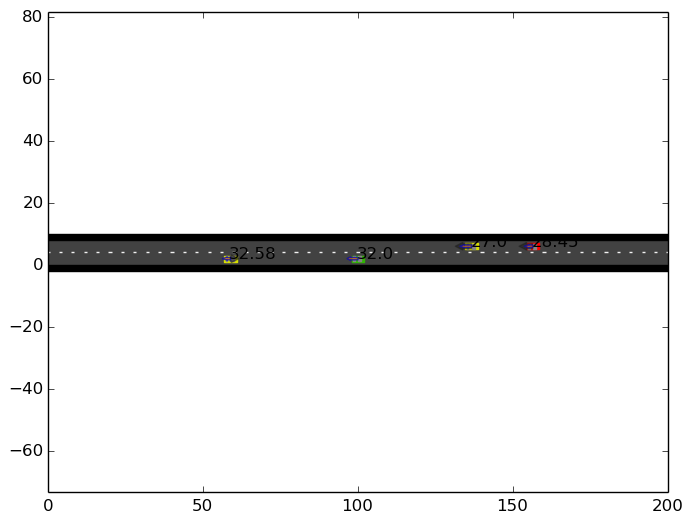

In [8]:
blas = 1
display_sim(pomdp,histS[blas],histA[blas])
#Warning! Only use if it crashes relatively early--unintelligible otherwise
#abs_display_sim(pomdp,histS[blas],histA[blas])

In [10]:
j = 52 #if there's early stopping, else j = n_ep
crash_rate = nb_early_term/j
println("$crash_rate +/- $(sqrt(crash_rate*(1.-crash_rate)/j))")
nb_early_term

0.0 +/- 0.0


0

In [13]:
#Calculate the total (discounted/undiscounted) cost, minus crashing
n_ep = 1
R_disc = zeros(n_ep)
R_MC = zeros(n_ep)
for (ep,R) in enumerate(Rs[1:n_ep])
    disc = 1.
    for i =1:length(R)-1
        r = R[i]
        R_disc[ep] += disc*r
        disc *= 0.99
        R_MC[ep] += r
    end
end

println((mean(R_MC),std(R_MC)))
println((mean(R_disc),std(R_disc)))
println(nb_early_term)
#ec=10:  ~30% crash, -0.08 reward
#ec=100: ~36% crash, -0.1578 reward
#ec=30: ~24.8% crash, -0.09 reward || 32.72% crash, -0.1467 reward (100 sim)
#ec=60: ~44% crash, -0.177 reward
###4 cars, 3 lanes: 41% crash rate, -0.126 reward

(-0.0013750000000000008,NaN)
(-0.0008875550006983789,NaN)
0


In [14]:
#Tree visualization--does not work
function MCTS.node_tag(s::MLState)
    return "[$(s.agent_pos),$(s.agent_vel)]"
end

MCTS.node_tag(a::MLAction) = "[$(a.vel),$(a.lane_change)]"
TreeVisualizer(policy, histS[450])


LoadError: LoadError: BoundsError: attempt to access 1-element Array{Array{MLState,1},1}:
 [MLState(1,31.0,false,[CarState((-1.0,1),1.0,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.5,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((-1.0,1),1.0,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.5,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((-1.0,1),1.0,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.5,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1))]),MLState(1,28.75,false,[CarState((0.0,1),33.800110041549374,-1,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((0.0,3),33.00850170056128,-1,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((200.0,1),27.55225610756444,0,BehaviorModel(IDMParam(1.5,1.5,1.4,28.386478791622846,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,2))]),MLState(1,29.5,false,[CarState((3.7875825311620304,1),33.192258444355105,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((3.193876275420962,2),32.25850170056128,1,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((199.10169208067333,1),27.676746904593276,0,BehaviorModel(IDMParam(1.5,1.5,1.4,28.386478791622846,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,2))]),MLState(1,28.0,false,[CarState((6.556776364428359,1),32.72710414981733,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((5.262752550841924,3),31.508501700561283,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((197.73425225911828,1),27.78305253851937,0,BehaviorModel(IDMParam(1.5,1.5,1.4,28.386478791622846,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,2))]),MLState(1,27.25,false,[CarState((10.102104476791355,1),32.364683719935954,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((7.894128826262886,3),30.9859433514908,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((197.5715416630078,1),27.87363408590805,0,BehaviorModel(IDMParam(1.5,1.5,1.4,28.386478791622846,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,2))]),MLState(1,27.0,false,[CarState((13.93811726674332,1),32.078245647378104,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((10.696086339880985,3),30.545614172287507,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((198.03926722743884,1),27.950674261343345,0,BehaviorModel(IDMParam(1.5,1.5,1.4,28.386478791622846,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,2))]),MLState(1,27.0,false,[CarState((17.7468015022769,1),31.849109084213136,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((13.355296969096615,3),30.171422503766323,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((198.75227292344636,1),28.016093118008907,0,BehaviorModel(IDMParam(1.5,1.5,1.4,28.386478791622846,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,2))]),MLState(1,27.0,false,[CarState((21.38363331543675,1),31.6638049495226,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((15.733863846921357,3),29.851233173367316,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((199.51434276195303,1),28.07156801384842,0,BehaviorModel(IDMParam(1.5,1.5,1.4,28.386478791622846,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,2))]),MLState(1,27.0,false,[CarState((24.8814870275787,1),31.51237978330458,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((17.872288726946845,3),29.575686405625255,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((-1.0,1),1.0,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.5,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1))]),MLState(1,27.0,false,[CarState((28.265771865057136,1),31.65331919836363,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((19.804053531165785,3),29.337426088060933,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.62558076529883,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1)),CarState((-1.0,1),1.0,0,BehaviorModel(IDMParam(1.0,1.0,2.0,27.5,4.0,4.0),MOBILParam(0.5,4.0,0.2),0.999,1))])  …  MLState(3,27.0,false,[CarState((156.18660219456632,1),32.586213251688314,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((63.55949403684808,3),27.399153687780952,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((120.3282992683822,3),28.220691957611812,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,27.0,false,[CarState((160.37626213333255,1),32.5862140663773,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((63.8588593026838,3),27.433797996053727,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((121.24381823659105,3),28.22068513352565,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,27.0,false,[CarState((164.56592268311553,1),32.586214768711386,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((64.18420779972409,3),27.466826116643055,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((122.15933208673529,3),28.2206797597247,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,27.0,false,[CarState((168.75558375964908,1),32.586215374185585,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((64.53432738720639,3),27.49830029263509,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((123.07484190652882,3),28.220675527987144,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,27.75,false,[CarState((172.94524529028828,1),32.58621589615798,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((64.9080526066827,3),27.52829018263415,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((123.99034855251918,3),28.220672195596276,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,27.75,false,[CarState((176.57240721240677,1),32.58621634614442,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((64.74177024365832,3),27.55686811599041,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((124.34335269921638,3),28.220669571418867,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,28.5,false,[CarState((180.1995694720151,1),32.58621673407258,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((64.59692133065113,3),27.58410624747766,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((124.69635487778054,3),28.22066750494229,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,29.25,false,[CarState((183.26423202256953,1),32.58621706850101,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((63.91000101625937,3),27.610074892162583,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((124.48685550648726,3),28.220665877641597,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,30.0,false,[CarState((185.7663948239453,1),32.58621735680793,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((62.68005718538131,3),27.634841594268178,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((123.71485491471846,3),28.220664596181297,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))]),MLState(3,30.0,false,[CarState((187.70605784155123,1),32.58621760535403,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.606308649646884,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((60.906188381082444,3),27.658470651513056,0,BehaviorModel(IDMParam(1.5,1.5,1.4,32.0683132851447,4.0,4.0),MOBILParam(0.25,4.0,0.2),0.99,5)),CarState((122.38035336185443,3),28.220663587061978,0,BehaviorModel(IDMParam(2.0,2.0,0.8,28.225645195372238,4.0,4.0),MOBILParam(0.0,4.0,0.2),0.95,3))])]
  at index [450]
while loading In[14], in expression starting on line 7

In [ ]:
#This stuff VVV is for dumping to a mp4 file--requires ffmpeg
using PyCall
@pyimport matplotlib.animation as anim

In [ ]:
X = reverse(histS)
Y = reverse(histA)
function func(x...)
    if length(X) < 1
        return
    end
    s = pop!(X)
    a = pop!(Y)
    visualize(pomdp,s,a)
end

In [ ]:
fig = figure()
ani=anim.FuncAnimation(fig,func)
fname = "MCTS_3lane5car.mp4"

ani[:save](fname, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"]);

# # call our new function to display the animation
display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
base64encode(open(readbytes,fname)),"""" type="video/mp4"></video>"""));